# G27
Dave Brunner

In [1]:
import glob
import os
import string

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import matplotlib.ticker as ticker

from sklearn.metrics import confusion_matrix

### Load Data

The names can be found in text files in a src directory, one file per language.

In the following you can find some utilities to load the data into pandas data frames. 

We will restrict to some common European languages. 

With the given selection, we will identify all the occurring characters and initialize an alphabet.<br>
For this alphabet, we will use a one-hot-encoding to map them into a vector space representation. 

Foresee a suitable character for the end of the word, e.g. 'END'.

In [2]:
srcdir = 'data/names'
languages = ["English", "French", "Italian", "German", "Spanish"]

In [3]:
# inspect the data directory
def findFiles(path):
    return glob.glob(path)

In [4]:
print('\n'.join(findFiles(os.path.join(srcdir, '*.txt'))))

data/names/Czech.txt
data/names/German.txt
data/names/Arabic.txt
data/names/Japanese.txt
data/names/Chinese.txt
data/names/Vietnamese.txt
data/names/Russian.txt
data/names/French.txt
data/names/Irish.txt
data/names/English.txt
data/names/Spanish.txt
data/names/Greek.txt
data/names/Italian.txt
data/names/Portuguese.txt
data/names/Scottish.txt
data/names/Dutch.txt
data/names/Korean.txt
data/names/Polish.txt


In [5]:
# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return lines


def load_data(srcdir, categories=None):
    names_list = []
    for filename in findFiles(os.path.join(srcdir, '*.txt')):
        category = os.path.splitext(os.path.basename(filename))[0]
        if not categories or category in categories:
            names = readLines(filename)
            names_list.extend([(name, category) for name in names])
    df = pd.DataFrame(names_list)
    df.columns = ["name", "lang"]
    return df

In [6]:
names = load_data(srcdir, categories=languages)
names.head()

,name,lang
0,Abbing,German
1,Abel,German
2,Abeln,German
3,Abt,German
4,Achilles,German


In [7]:
maxlen = np.max([len(name) for name in names.name])
print("Maximum name length: ", maxlen)

Maximum name length:  18


In [8]:
print(f'There are {len(names)} names in the dataset')

There are 5676 names in the dataset


In [9]:
alphabet = sorted(list(set(''.join([name for name in names.name]))))
alphabet.append('END')
len_alphabet = len(alphabet)
char_index = dict((c, i) for i, c in enumerate(alphabet))
print("Size of alphabet: ", len_alphabet)
print(alphabet)

Size of alphabet:  74
[' ', "'", 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'Á', 'É', 'ß', 'à', 'á', 'ä', 'ç', 'è', 'é', 'ê', 'ì', 'í', 'ñ', 'ò', 'ó', 'ö', 'ù', 'ú', 'ü', 'END']


In [10]:
names.groupby('lang')['name'].count() / len(names)

lang
English    0.646230
French     0.048802
German     0.127555
Italian    0.124912
Spanish    0.052502
Name: name, dtype: float64

### Vector Representations

Now construct the vector representation by using one-hot-vectors. 

In [11]:
language_to_index = {country: index for index, country in enumerate(names.lang.unique())}
index_to_language = {index: country for index, country in enumerate(names.lang.unique())}


def onehot(i, length):
    v = np.zeros(length);
    v[i] = 1
    return v


def name_representation(name, maxlen):
    name_trunc = str(name)[0:maxlen]
    size = len(char_index)
    vector = [onehot(char_index[j], size) for j in str(name)]
    # fill the rest with 
    for k in range(0, maxlen - len(str(name))):
        vector.append(onehot(char_index['END'], size))
    return vector


def lang_representation(language, language_to_index):
    y = np.zeros(len(language_to_index))
    y[language_to_index[language]] = 1
    return y


def lang_from_output(score):
    return index_to_language[np.argmax(score)]


def predict(name, model):
    score = model.predict(np.array([name_representation(name, maxlen)]))[0]
    return lang_from_output(score)

### Prepare train/test

Split the data into train/test

Shuffle the data

Transform the names data into a suitable vector respresentation:
* names into numpy arrays of shape (*,maxlen,len_alphabet)
* language into numpy array of shape (*,len(languages))



In [12]:
test_split = 0.2

# Shuffle and split names data
names = names.sample(frac=1).reset_index(drop=True)
print(names.head())

train = names[int(len(names) * test_split):]
test = names[:int(len(names) * test_split)]

       name     lang
0  Ludgrove  English
1    Grogan  English
2    Grillo  Italian
3      Corr  English
4   Goretti  Italian


In [13]:
# Map train and test data into vector space (one-hot-vectors)
X_train = np.array([name_representation(name, maxlen) for name in train.name])
Y_train = np.array([lang_representation(lang, language_to_index) for lang in train.lang])

X_test = np.array([name_representation(name, maxlen) for name in test.name])
Y_test = np.array([lang_representation(lang, language_to_index) for lang in test.lang])

In [14]:
print(X_train.shape)
print(X_test.shape)
print(X_train[0].shape)

(4541, 18, 74)
(1135, 18, 74)
(18, 74)


### Define and Train Model: Single Layer with SimpleRNN

Create an RNN consisting of a single layer with a SimpleRNN and a softmax.

Then train the model. Play with different number of hidden units in the layer to obtain a good accuracy.

In [15]:
from keras.src.layers import SimpleRNN, Dense, InputLayer
from keras import Sequential

def build_model(n_hidden):
    model = Sequential()
    model.add(InputLayer(shape=(maxlen, len_alphabet)))
    model.add(SimpleRNN(n_hidden))
    model.add(Dense(len(languages), activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

model = build_model(n_hidden=128)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 128)            │        25,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,629 (104.02 KB)

 Trainable params: 26,629 (104.02 KB)

 Non-trainable params: 0 (0.00 B)

In [16]:
def plot_history(history):
    plt.figure(figsize=(13, 3))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.legend()
    plt.title('Training and Validation Loss')
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='test')
    plt.legend()
    plt.title('Training and Validation Accuracy')
    plt.show()

In [34]:
model = build_model(n_hidden=32)
history = model.fit(X_train, Y_train, epochs=20, batch_size=128, validation_data=(X_test, Y_test), verbose=0)

Epoch 1/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4679 - loss: 1.3875 - val_accuracy: 0.6423 - val_loss: 1.1175
Epoch 2/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6505 - loss: 1.0946 - val_accuracy: 0.6432 - val_loss: 1.0798
Epoch 3/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6442 - loss: 1.0662 - val_accuracy: 0.6767 - val_loss: 0.9906
Epoch 4/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6874 - loss: 0.9467 - val_accuracy: 0.6916 - val_loss: 0.9117
Epoch 5/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7054 - loss: 0.8809 - val_accuracy: 0.6996 - val_loss: 0.8651
Epoch 6/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7129 - loss: 0.8221 - val_accuracy: 0.7119 - val_loss: 0.8229
Epoch 7/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7359 - loss: 0.7693 - val_accuracy: 0.7128 - val_loss: 0.7981
Epoch 8/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7407 - loss: 0.7501 - val_accuracy: 0.7278 - val_loss:

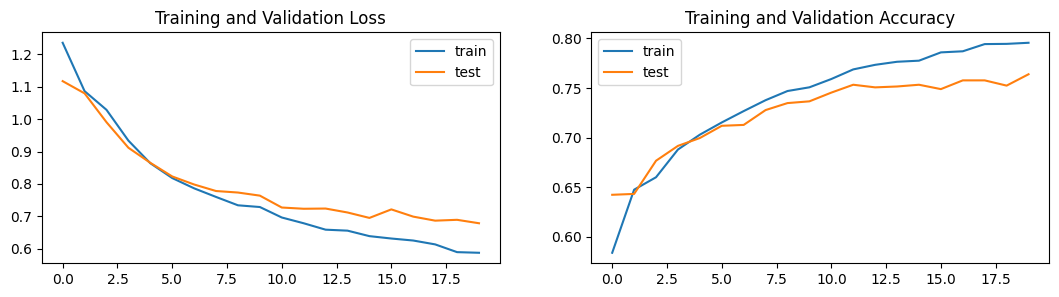

In [35]:
plot_history(history)

In [19]:
model = build_model(n_hidden=64)
history = model.fit(X_train, Y_train, epochs=20, batch_size=128, validation_data=(X_test, Y_test), verbose=0)

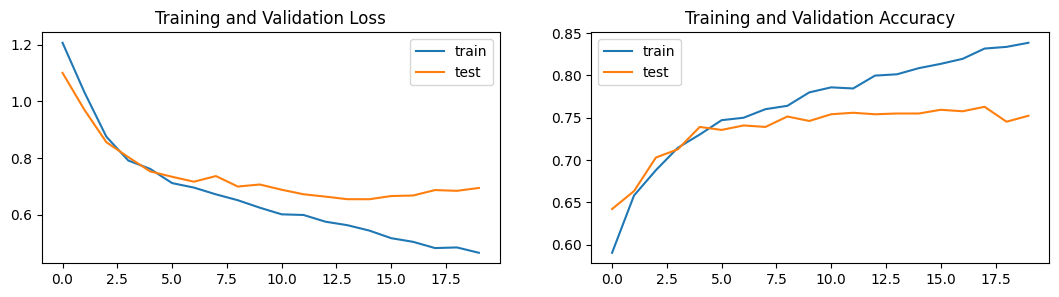

In [20]:
plot_history(history)

In [21]:
model = build_model(n_hidden=128)
history = model.fit(X_train, Y_train, epochs=20, batch_size=128, validation_data=(X_test, Y_test), verbose=0)

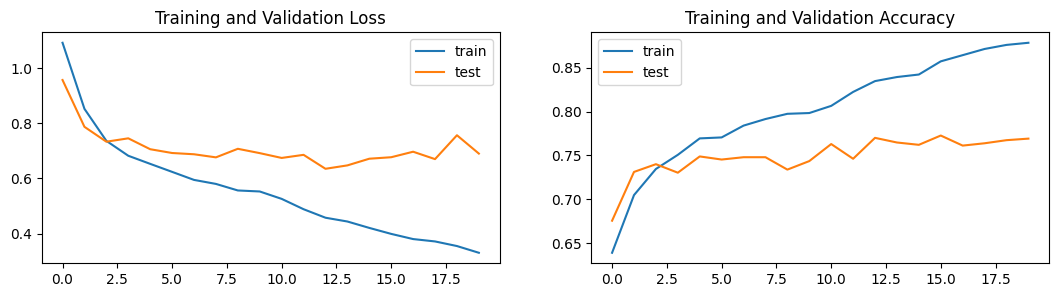

In [22]:
plot_history(history)

In [23]:
model = build_model(n_hidden=256)
history = model.fit(X_train, Y_train, epochs=20, batch_size=128, validation_data=(X_test, Y_test), verbose=0)

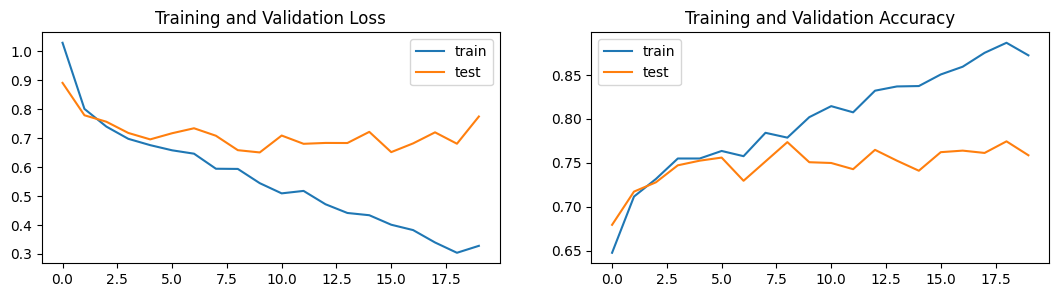

In [24]:
plot_history(history)

In [25]:
model = build_model(n_hidden=512)
history = model.fit(X_train, Y_train, epochs=20, batch_size=64, validation_data=(X_test, Y_test), verbose=0)

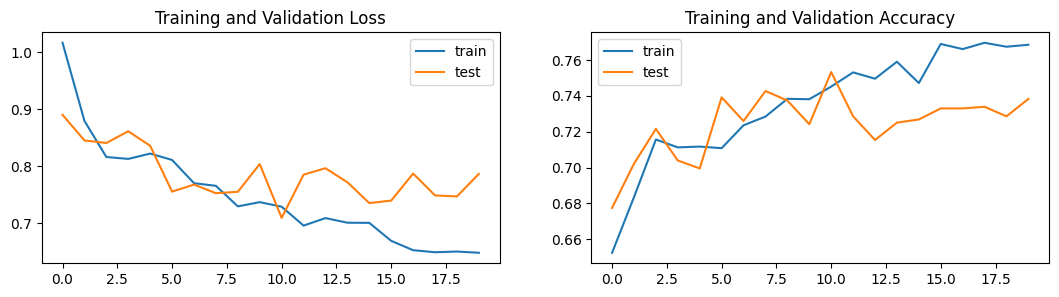

In [26]:
plot_history(history)

#### Findings

The performance in general is quite good on the traaining set, but the model is overfitting. Because the accuracy on the test set is really poor. The model is not able to generalize well.
The difference in different number of hidden units, number of epochs, batch size do not have a big influence on the performance of the model.


### Implement Model with several SimpleRNN Layers

In [27]:
def build_model_multi(n_hidden):
    model = Sequential()
    model.add(InputLayer(shape=(maxlen, len_alphabet)))
    model.add(SimpleRNN(n_hidden, return_sequences=True))
    model.add(SimpleRNN(n_hidden, return_sequences=True))
    model.add(SimpleRNN(n_hidden, return_sequences=True))
    model.add(SimpleRNN(n_hidden, return_sequences=True))
    model.add(SimpleRNN(n_hidden))
    model.add(Dense(len(languages), activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model
model = build_model_multi(n_hidden=128)
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_6 (SimpleRNN)        │ (None, 18, 128)        │        25,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_7 (SimpleRNN)        │ (None, 18, 128)        │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_8 (SimpleRNN)        │ (None, 18, 128)        │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_9 (SimpleRNN)        │ (None, 18, 128)        │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_10 (SimpleRNN)       │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 158,213 (618.02 KB)

 Trainable params: 158,213 (618.02 KB)

 Non-trainable params: 0 (0.00 B)

In [28]:
model = build_model(n_hidden=32)
history = model.fit(X_train, Y_train, epochs=20, batch_size=128, validation_data=(X_test, Y_test), verbose=0)

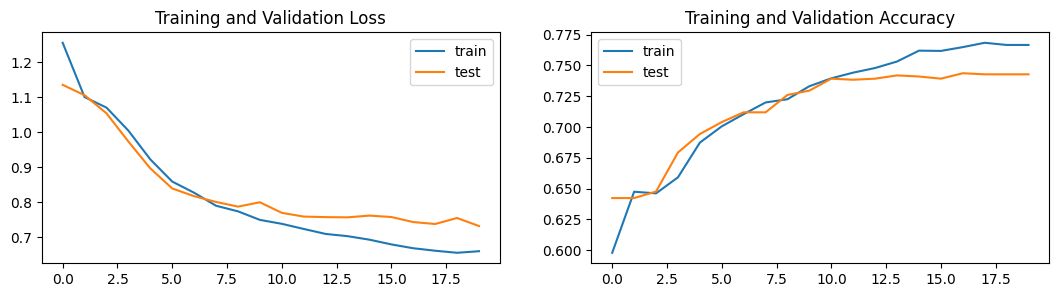

In [29]:
plot_history(history)

In [30]:
model = build_model(n_hidden=128)
history = model.fit(X_train, Y_train, epochs=20, batch_size=128, validation_data=(X_test, Y_test), verbose=0)

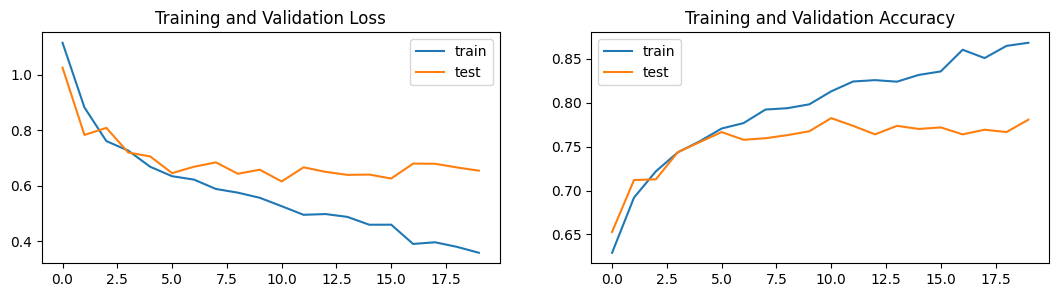

In [31]:
plot_history(history)

#### Findings

...


### Class Imbalance Handling

Choose a method to address the class imbalance seen in the given example.
- minority resampling 
- class weights in the loss

Implement it and incorporate it in the training.
Evaluate the results and compare it with the results obtained with the unbalanced training.  

In [32]:
### START YOUR CODE

# train...

### END YOUR CODE